
### In this notebook, we aimed at calculating the mAP50 and mAP75 by deploying the state-of-the-art instance segmentation model - Mask-RCNN. 

1. Firstly, we were going to look into the coco dataset. including the loading and extraction.

2. Then, we deployed the Mask-RCNN model for visulization.

3. In the later part, Evaluation Matrix (AP 50 and AP 75) was defined step by step.

4. The result of those scorse was shown.
![](maskrcnn.png)

In [1]:
#import all the libraries
import cv2
import numpy as np
import pandas as pd
import os,sys,re
from PIL import Image as PILImage
import torch
import torchvision
from torchvision import transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils import data
import matplotlib.pyplot as plt
import torch.utils as utils
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

device = torch.device('cpu')
if torch.cuda.is_available():
   device = torch.device('cuda')

## Coco dataset handling

In [2]:
%matplotlib inline
import json
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import cv2
import os
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [3]:
dataDir='.'
dataType='train2017'
annFile='annotation_little_v5.json'
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


Number of images: 5830


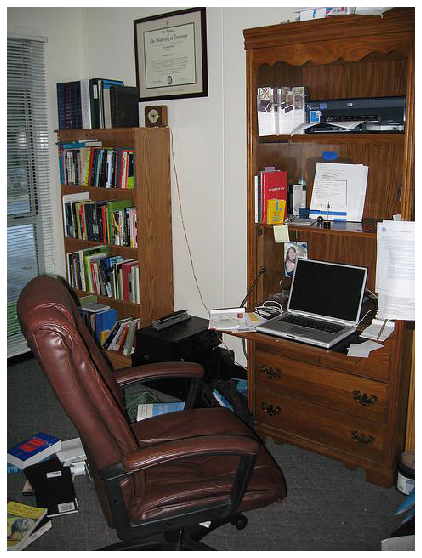

In [5]:
#Example of the images in the coco dataset
catIds = coco.getCatIds();
imgIds = coco.getImgIds()
print('Number of images:', len(imgIds))
img = coco.loadImgs(imgIds[25])[0]  #number 25 image
#plot image
I = io.imread('images/' + img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()

## Mask RCNN

The Mask RCNN model was pretrained with coco dataset

In [5]:
# get MS COCO classes
coco_object_categories=[]
coco_classes={}
with open("coco_labels.txt","r") as f:
     for id, l in enumerate(f.readlines()):
         # get the class label
         l = re.sub('[\d]+\W+','', l.rstrip())
         # remove the old stuff
         if l == 'banner':
            break
         else:    
            coco_object_categories.append(l)
            coco_classes[l] = id

print(coco_object_categories, coco_classes)
img_max_size = [800,800]

['unlabeled', 'person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'pottedplant', 'sofa', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush'] {'u

In [ ]:
#define the maskrcnn model from torchvision
maskrcnn_args = {'num_classes':91}
maskrcnn_model = model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, **maskrcnn_args)
if torch.cuda.is_available():
    maskrcnn_model.cuda()
maskrcnn_model.eval()

In [7]:
#define the function for deployment for the image with maskrcnn with specific class of mask
def deploy_mask_rcnn(im, class_input):
    threshold = 0.75
    img = PILImage.open(im)
    img = np.array(img)
    img = transforms.ToTensor()(img).cuda()
    out = maskrcnn_model([img])
    # scores + bounding boxes + labels + masks
    scores = out[0]['scores']
    bboxes = out[0]['boxes']
    classes = out[0]['labels']
    mask = out[0]['masks']
    
    best_idx = np.where(scores.cpu() > threshold)
    best_scores = scores[best_idx]
    best_bboxes = bboxes[best_idx]
    best_classes = classes[best_idx]
    best_mask = mask[best_idx]
    
    k = []
    for idc, c in enumerate(best_classes):
        if c in class_input:
            k.append(idc)
    best_scores = scores[k]
    best_bboxes = bboxes[k]
    best_classes = classes[k]
    best_mask = mask[k]
    return best_scores, best_bboxes,best_classes,best_mask

In [8]:
#define the function for changing the array of the mask for better comparison for the metric
def mask_one_array(mask):
    array = []
    for k in range(mask.shape[0]):
        color_array = np.zeros([mask.shape[2], mask.shape[3]], dtype=np.uint8)
        found = mask[k][0].detach().clone().cpu().numpy()
        color_array[found>0.5] = 1
        array.append(color_array)
    return array

In [9]:
#define the iou function
SMOOTH = 1e-6
def iou_cal(outputs, labels):
    
    intersection = (outputs & labels).sum()  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).sum()         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We add the smooth division to avoid 0/0
    return np.float32(np.round(iou, 5))

In [11]:
#define a plot function for visualize the bounding box and mask in a image
def plot_mask_rcnn(img_number):
    img = coco.loadImgs(imgIds[img_number])[0]
    img_ = "images/" + img['file_name']
    
    best_scores, best_bboxes,classes,mask = deploy_mask_rcnn(img_, [1,62,63,67,70])
    
    plt.figure(figsize = (15,8))
    # for the objects with scores>threshold: 
    # add bbox and mask 
    if len(best_bboxes)>0:
        color_array = np.zeros([mask[0].shape[1], mask[0].shape[2],3], dtype=np.uint8)
        bgr_img = cv2.imread(img_)
        ax = plt.gca()

        for id, b in enumerate(best_bboxes):
            if classes[id] == 1:
                found = mask[id][0].detach().clone().cpu().numpy()
                color_array[found>0.5] = [255,0,0]
            elif classes[id] ==62:
                found = mask[id][0].detach().clone().cpu().numpy()
                color_array[found>0.5] = [0,255,0]
            elif classes[id] ==63:
                found = mask[id][0].detach().clone().cpu().numpy()
                color_array[found>0.5] = [0,0,255]
            elif classes[id] ==67:
                found = mask[id][0].detach().clone().cpu().numpy()
                color_array[found>0.5] = [120,120,0]
            elif classes[id] ==70:
                found = mask[id][0].detach().clone().cpu().numpy()
                color_array[found>0.5] = [0,120,120]
            
            rect = Rectangle((b[0],b[1]), b[2]-b[0], b[3]-b[1], linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        added_image = cv2.addWeighted(bgr_img, 1, color_array, 0.5, 0)  
        plt.axis('off')
        plt.imshow(added_image)
        plt.show()

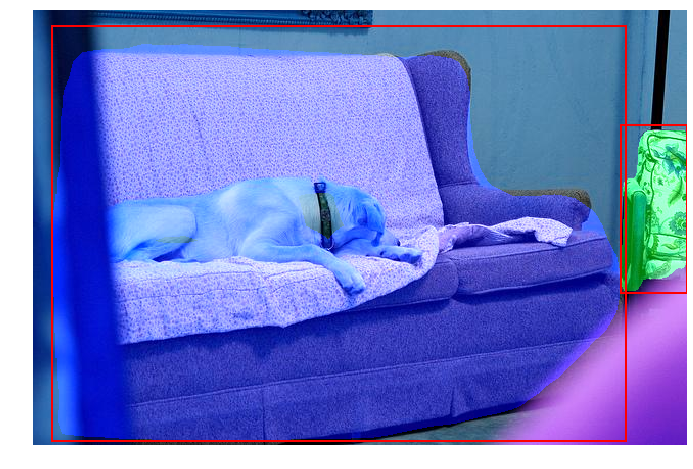

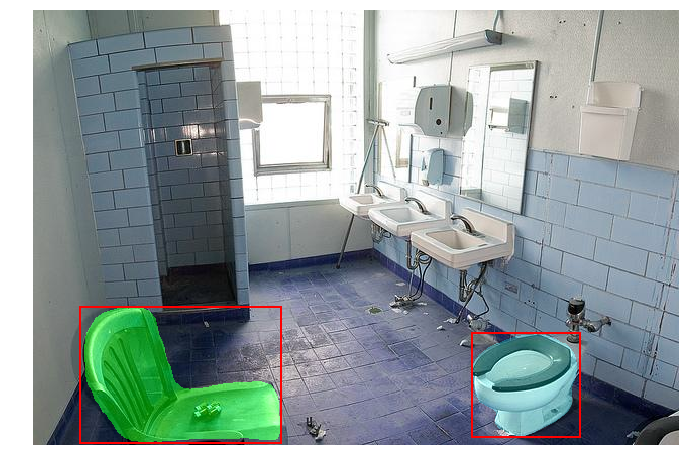

In [12]:
plot_mask_rcnn(20)
plot_mask_rcnn(130)

## Evaluation Metric

#### Firstly, we used class of 'Person' as example to show step-by-step method of the calculation of mAP50 as examples.

### Step i. 
Find the intercept over union (IoU) of the ground truth masks and the predicted masks. In each predicted mask, the maximum value IoU across every ground truth in the same images are used. 

In [ ]:
'''
Getting the iou and table for the metric (Class 1: Person)
'''

df_person = []         #save the table to the list
ct_person = 0    #save the number of gt

#For illustration, we only run a loop for first 1000 images(given the set have 5830 images)
for n in range(1000):     
    print(n)
    #detect if the image consist of any of class 1 (person)
    img = coco.loadImgs(imgIds[n])[0]
    scores,bboxes,classes,mask = deploy_mask_rcnn("images/" + img['file_name'],1)
    if len(classes) == 0:
        continue
    length_pred = len(classes)
    array = mask_one_array(mask)

    annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    anns = coco.loadAnns(annIds)
    length_label = len(anns)
    
    # saving a list with the format [n, 'person', scores_, max_iou]
    for t in range(length_pred):
        i = []
        
        for k in range(length_label):
            
            if anns[k]['category_id'] == 1:
                iou = iou_cal(array[t],coco.annToMask(anns[k]))
                i.append(iou)
                ct_person += 1
            if k == length_label-1 and i == []:
                i.append(0)
        
        max_iou = np.max(i)
        scores_ = np.round(scores[t].detach().numpy(),5)        
        dict_ = [n, 'person', scores_, max_iou]
        df_person.append(dict_)
    

In [ ]:
print(ct_person) 
print(df_person)

So we can see that there are 3542 image consisting of class of 'person'. The df_person also saved a list of all the required IOU and scores data for each image.

Next we convert the iou list to Pandas dataframe for easy manipulation.

In [395]:
#import the iou table to pandas dataframe for easy manupilation
df_person = pd.DataFrame(df_, columns = ['images', 'Detections', 'Confidences', 'max_iou'])

In [399]:
df_person.head()

,images,Detections,Confidences,max_iou
0,0,person,0.99667,0.93657
1,0,person,0.99581,0.94061
2,0,person,0.99518,0.95756
3,0,person,0.99262,0.92621
4,0,person,0.98167,0.87041


### Step ii.
Find the True Positive (TP) and False Positive (FP):

      if IoU higher than the threshold, the observation is treated as TP 
      (where threshold for AP50 was 50% and AP75 was 75% correspondingly)
           
      else treated as FP.

In [400]:
'''
Creating TP and FP column
'''
df_person['TP'] = df_person.max_iou >= 0.5
df_person['FP'] = df_person.max_iou < 0.5

### Step iii.
Find the accumulated TP and FP columns.

In [413]:
#sorting by Confidences
df_person_sort = df_person.sort_values('Confidences', ascending=False)
df_person_sort['acc_TP'] = df_person_sort.TP.cumsum()
df_person_sort['acc_FP'] = df_person_sort.FP.cumsum()

### Step iv.
Find the accumulated precision and recall by the TP, FP False Negative (FN):

       precision=  TP/(TP+FP)              recall=  TP/(TP+FN)
   where (TP+FN) equals to the total number of ground truth masks.

In [433]:
#looping all the table
for k in range(len(df)):
    df_person_sort['Precision'].iloc[k] = df_person_sort.acc_TP.iloc[k]/(k+1)
    df_person_sort['Recall'].iloc[k] = df_person_sort.acc_TP.iloc[k]/3542

Text(0.5, 1.0, 'Person-Precision Recall Curve')

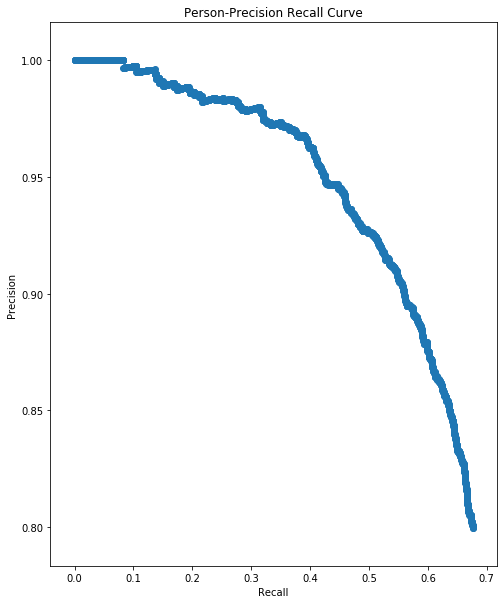

In [443]:
#ploting the Precision over Recall Curve before grounding 
plt.scatter(df_person_sort.Recall,df_person_sort.Precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Person-Precision Recall Curve')

### Step v.
Extract the precision and recall columns for plotting precision over recall graph.

In [454]:
#sort out only the precision and recall for grounding
df_person_sort_PR = df_person_sort[['Precision','Recall']]
df_person_sort_PR = df_person_sort_PR.sort_values('Recall')

### Step vi.
Apply interpolation function p_interp (r)=max┬(r ̃≥r)⁡〖(r ̃)〗 to flatten the graph.

In [ ]:
length_df = len(df_sort_PR)
for k in reversed(range(length_df)):
    if df_person_sort_PR.Precision.iloc[k] > df_person_sort_PR.Precision.iloc[k - 1]:
        df_person_sort_PR.Precision.iloc[k - 1] = df_person_sort_PR.Precision.iloc[k]

Text(0.5, 1.0, 'Person-Precision Recall Curve')

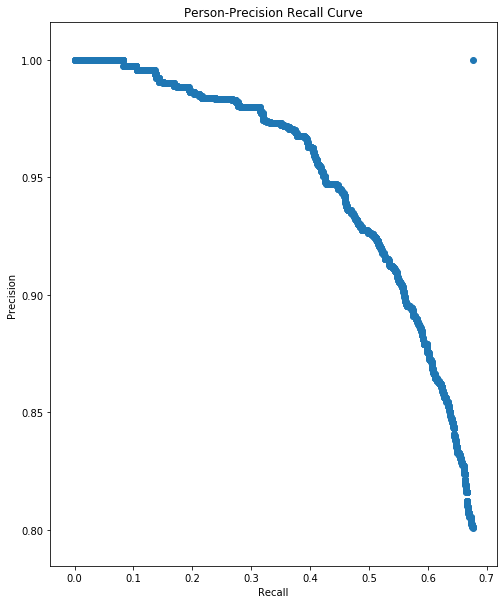

In [467]:
#ploting the Precision over Recall Curve after grounding 
plt.scatter(df_person_sort_PR.Recall,df_person_sort_PR.Precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Person-Precision Recall Curve')

### Step vii.
Finally, the AP of the class was calculated by summing the area under curve (AUC)

In [475]:
# AP by All point interpolation
AP_person = 0
for k in reversed(range(1,length_df)):
    ap = df_person_sort_PR.Precision.iloc[k]*(df_person_sort_PR.Recall.iloc[k]-df_person_sort_PR.Recall.iloc[k-1])
    AP_person += ap
AP_person

0.6432169105806282

Text(0.5, 1.0, 'Person-Precision Recall Curve')

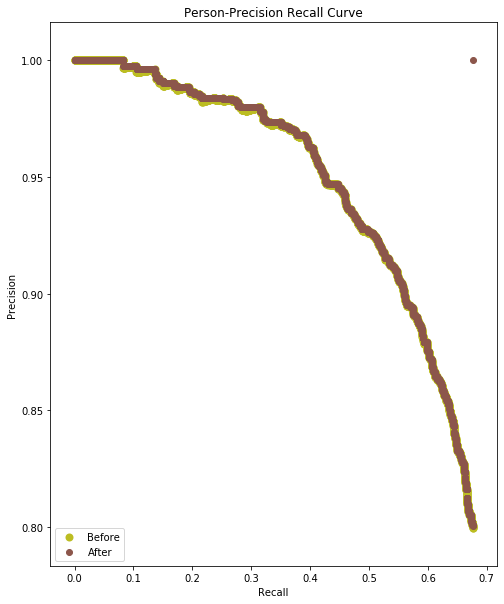

In [474]:
#comparison of the 2 curves
plt.scatter(df_person_sort.Recall,df_person_sort.Precision, c='#bcbd22', linewidths=2,label = 'Before grouding')
plt.scatter(df_person_sort_PR.Recall,df_person_sort_PR.Precision,c='#8c564b', linewidths=1, label='After grounding')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Person-Precision Recall Curve')

-----
### Now, we find the same AP for the other 4 classes.

#### Chair

In [ ]:
# Getting the iou and table for the metric (Class 62: chair)
df_chair = []  #save the table to the list
ct_chair = 0   #save the number of gt
for n in range(1000):
    print(n)
    img = coco.loadImgs(imgIds[n])[0]
    scores,bboxes,classes,mask = deploy_mask_rcnn("images/" + img['file_name'],62)
    if len(classes) == 0:
        continue
    length_pred = len(classes)
    array = mask_one_array(mask)

    annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    anns = coco.loadAnns(annIds)
    length_label = len(anns)
    
    for t in range(length_pred):
        i = []
        
        for k in range(length_label):
            
            if anns[k]['category_id'] == 62:
                iou = iou_cal(array[t],coco.annToMask(anns[k]))
                i.append(iou)
                ct_chair += 1
            if k == length_label-1 and i == []:
                i.append(0)
        
        max_iou = np.max(i)
        scores_ = np.round(scores[t].detach().numpy(),5)        
        dict_ = [n, 'chair', scores_, max_iou]
        df_chair.append(dict_)

In [ ]:
print(ct_chair) 
print(df_chair)

In [43]:
#import the iou table to pandas dataframe for easy manupilation
df_chair = pd.DataFrame(df_chair, columns = ['images', 'Detections', 'Confidences', 'max_iou'])

#creating TP and FP column
df_chair['TP'] = df_chair.max_iou >= 0.5
df_chair['FP'] = df_chair.max_iou < 0.5

#sorting by Confidences
df_chair_sort = df_chair.sort_values('Confidences', ascending=False)
df_chair_sort['acc_TP'] = df_chair_sort.TP.cumsum()
df_chair_sort['acc_FP'] = df_chair_sort.FP.cumsum()

#Calculating the Precision and Recall
df_chair_sort['Precision'] = 0
df_chair_sort['Recall'] = 0
for k in range(len(df_chair)):
    df_chair_sort['Precision'].iloc[k] = df_chair_sort.acc_TP.iloc[k]/(k+1)
    df_chair_sort['Recall'].iloc[k] = df_chair_sort.acc_TP.iloc[k]/3403

#sort out only the precision and recall for grounding
df_chair_sort_PR = df_chair_sort[['Precision','Recall']]
df_chair_sort_PR = df_chair_sort_PR.sort_values('Recall')

length_df = len(df_chair_sort_PR)
for k in reversed(range(length_df)):
    if df_chair_sort_PR.Precision.iloc[k] > df_chair_sort_PR.Precision.iloc[k - 1]:
        df_chair_sort_PR.Precision.iloc[k - 1] = df_chair_sort_PR.Precision.iloc[k]

# AP by All point interpolation
AP_chair = 0
for k in reversed(range(1,length_df)):
    ap = df_chair_sort_PR.Precision.iloc[k]*(df_chair_sort_PR.Recall.iloc[k]-df_chair_sort_PR.Recall.iloc[k-1])
    AP_chair += ap

print('AP50-chair: ', AP_chair)

AP50-chair:  0.3299467040975858


Text(0.5, 1.0, 'Precision Recall Curve - Chair')

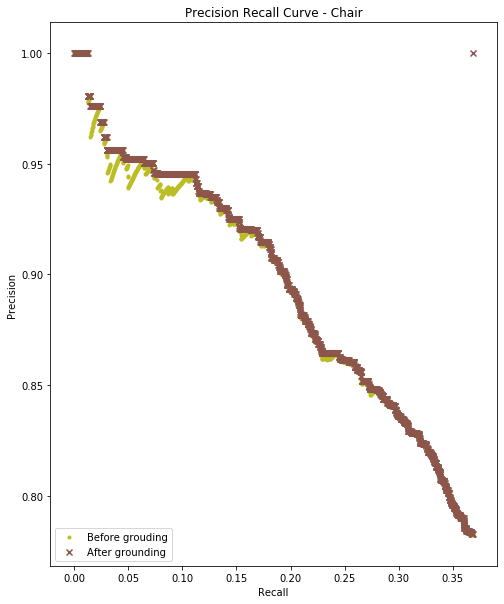

In [51]:
#comparison of the 2 curves
plt.scatter(df_chair_sort.Recall,df_chair_sort.Precision, c='#bcbd22',marker='.', linewidths=1,label = 'Before grouding')
plt.scatter(df_chair_sort_PR.Recall,df_chair_sort_PR.Precision,c='#8c564b',marker='x', linewidths=1, label='After grounding')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve - Chair')

#### Couch

In [ ]:
# Getting the iou and table for the metric (Class 63: couch)
df_couch = []  #save the table to the list
ct_couch = 0   #save the number of gt
for n in range(1000):
    print(n)
    img = coco.loadImgs(imgIds[n])[0]
    scores,bboxes,classes,mask = deploy_mask_rcnn("images/" + img['file_name'],63)
    if len(classes) == 0:
        continue
    length_pred = len(classes)
    array = mask_one_array(mask)

    annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    anns = coco.loadAnns(annIds)
    length_label = len(anns)
    
    for t in range(length_pred):
        i = []
        
        for k in range(length_label):
            
            if anns[k]['category_id'] == 63:
                iou = iou_cal(array[t],coco.annToMask(anns[k]))
                i.append(iou)
                ct_couch += 1
            if k == length_label-1 and i == []:
                i.append(0)
        
        max_iou = np.max(i)
        scores_ = np.round(scores[t].detach().numpy(),5)        
        dict_ = [n, 'chair', scores_, max_iou]
        df_couch.append(dict_)

In [30]:
df_couch = pd.read_csv('df_couch.csv')

In [31]:
#import the iou table to pandas dataframe for easy manupilation
df_couch = pd.DataFrame(df_couch, columns = ['images', 'Detections', 'Confidences', 'max_iou'])

#save to .csv file
pd.to_csv('df_couch.csv')

#read from the csv file
df_couch = pd.read_csv('df_couch.csv')

#creating TP and FP column
df_couch['TP'] = df_couch.max_iou >= 0.5
df_couch['FP'] = df_couch.max_iou < 0.5

#sorting by Confidences
df_couch_sort = df_couch.sort_values('Confidences', ascending=False)
df_couch_sort['acc_TP'] = df_couch_sort.TP.cumsum()
df_couch_sort['acc_FP'] = df_couch_sort.FP.cumsum()

#Calculating the Precision and Recall
df_couch_sort['Precision'] = 0
df_couch_sort['Recall'] = 0
for k in range(len(df_couch)):
    df_couch_sort['Precision'].iloc[k] = df_couch_sort.acc_TP.iloc[k]/(k+1)
    df_couch_sort['Recall'].iloc[k] = df_couch_sort.acc_TP.iloc[k]/ct_couch

#sort out only the precision and recall for grounding
df_couch_sort_PR = df_couch_sort[['Precision','Recall']]
df_couch_sort_PR = df_couch_sort_PR.sort_values('Recall')

length_df = len(df_couch_sort_PR)
for k in reversed(range(length_df)):
    if df_couch_sort_PR.Precision.iloc[k] > df_couch_sort_PR.Precision.iloc[k - 1]:
        df_couch_sort_PR.Precision.iloc[k - 1] = df_couch_sort_PR.Precision.iloc[k]

# AP by All point interpolation
AP_couch = 0
for k in reversed(range(1,length_df)):
    ap = df_couch_sort_PR.Precision.iloc[k]*(df_couch_sort_PR.Recall.iloc[k]-df_couch_sort_PR.Recall.iloc[k-1])
    AP_couch += ap

print('AP50-couch: ', AP_couch)

AP50-couch:  0.38701163204909417


Text(0.5, 1.0, 'Precision Recall Curve - Couch')

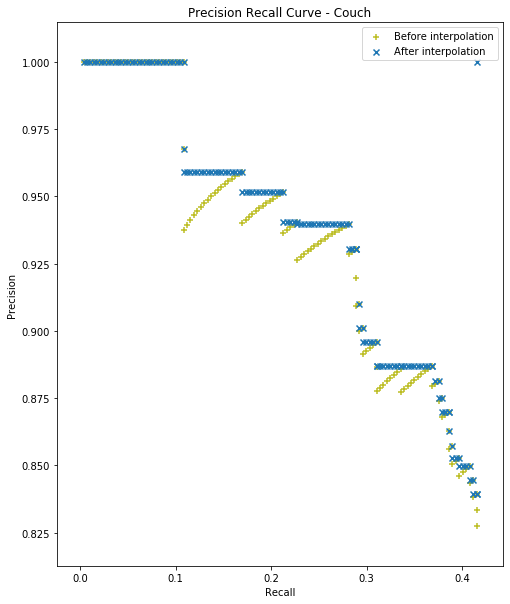

In [41]:
#comparison of the 2 curves
plt.scatter(df_couch_sort.Recall,df_couch_sort.Precision, marker="+", c='#bcbd22', linewidths=0.1,label = 'Before interpolation')
plt.scatter(df_couch_sort_PR.Recall,df_couch_sort_PR.Precision, marker="x", linewidths=0.1, label='After interpolation')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve - Couch')

#### Dining Table

In [ ]:
# Getting the iou and table for the metric (Class 67: dining table)
df_table = []  #save the table to the list
ct_table = 0   #save the number of gt
for n in range(1000):
    print(n)
    img = coco.loadImgs(imgIds[n])[0]
    scores,bboxes,classes,mask = deploy_mask_rcnn("images/" + img['file_name'],67)
    if len(classes) == 0:
        continue
    length_pred = len(classes)
    array = mask_one_array(mask)

    annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    anns = coco.loadAnns(annIds)
    length_label = len(anns)
    
    for t in range(length_pred):
        i = []
        
        for k in range(length_label):
            
            if anns[k]['category_id'] == 67:
                iou = iou_cal(array[t],coco.annToMask(anns[k]))
                i.append(iou)
                ct_table += 1
            if k == length_label-1 and i == []:
                i.append(0)
        
        max_iou = np.max(i)
        scores_ = np.round(scores[t].detach().numpy(),5)        
        dict_ = [n, 'dining table', scores_, max_iou]
        df_table.append(dict_)

In [517]:
print(ct_table)
print(len(df_table))

822
427


In [519]:
#import the iou table to pandas dataframe for easy manupilation
df_table = pd.DataFrame(df_table, columns = ['images', 'Detections', 'Confidences', 'max_iou'])

#creating TP and FP column
df_table['TP'] = df_table.max_iou >= 0.5
df_table['FP'] = df_table.max_iou < 0.5

#sorting by Confidences
df_table_sort = df_table.sort_values('Confidences', ascending=False)
df_table_sort['acc_TP'] = df_table_sort.TP.cumsum()
df_table_sort['acc_FP'] = df_table_sort.FP.cumsum()

#Calculating the Precision and Recall
df_table_sort['Precision'] = 0
df_table_sort['Recall'] = 0
for k in range(len(df_table)):
    df_table_sort['Precision'].iloc[k] = df_table_sort.acc_TP.iloc[k]/(k+1)
    df_table_sort['Recall'].iloc[k] = df_table_sort.acc_TP.iloc[k]/ct_table

#sort out only the precision and recall for grounding
df_table_sort_PR = df_table_sort[['Precision','Recall']]
df_table_sort_PR = df_table_sort_PR.sort_values('Recall')

length_df = len(df_table_sort_PR)
for k in reversed(range(length_df)):
    if df_table_sort_PR.Precision.iloc[k] > df_table_sort_PR.Precision.iloc[k - 1]:
        df_table_sort_PR.Precision.iloc[k - 1] = df_table_sort_PR.Precision.iloc[k]

# AP by All point interpolation
AP_table = 0
for k in reversed(range(1,length_df)):
    ap = df_table_sort_PR.Precision.iloc[k]*(df_table_sort_PR.Recall.iloc[k]-df_table_sort_PR.Recall.iloc[k-1])
    AP_table += ap

print('AP50-Dining Table: ', AP_table)

AP50-Dining Table:  0.261999283270184


In [520]:
df_table.to_csv('df_table.csv')

Text(0.5, 1.0, 'Person-Precision Recall Curve')

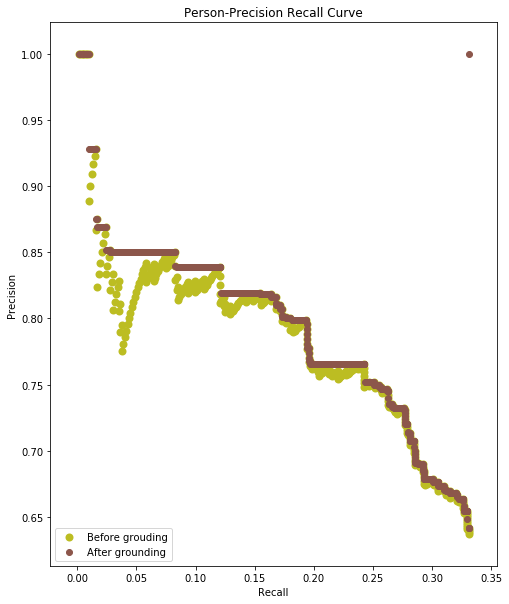

In [521]:
#comparison of the 2 curves
plt.scatter(df_table_sort.Recall,df_table_sort.Precision, c='#bcbd22', linewidths=2,label = 'Before grouding')
plt.scatter(df_table_sort_PR.Recall,df_table_sort_PR.Precision,c='#8c564b', linewidths=1, label='After grounding')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Person-Precision Recall Curve')

#### Toilet

In [ ]:
# Getting the iou and table for the metric (Class 67: dining table)
df_toilet = []  #save the table to the list
ct_toilet = 0   #save the number of gt
for n in range(1000):
    print(n)
    img = coco.loadImgs(imgIds[n])[0]
    scores,bboxes,classes,mask = deploy_mask_rcnn("images/" + img['file_name'],70)
    if len(classes) == 0:
        continue
    length_pred = len(classes)
    array = mask_one_array(mask)

    annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    anns = coco.loadAnns(annIds)
    length_label = len(anns)
    
    for t in range(length_pred):
        i = []
        
        for k in range(length_label):
            
            if anns[k]['category_id'] == 70:
                iou = iou_cal(array[t],coco.annToMask(anns[k]))
                i.append(iou)
                ct_toilet += 1
            if k == length_label-1 and i == []:
                i.append(0)
        
        max_iou = np.max(i)
        scores_ = np.round(scores[t].detach().numpy(),5)        
        dict_ = [n, 'toilet', scores_, max_iou]
        df_toilet.append(dict_)

In [523]:
print(ct_toilet)
print(len(df_toilet))

3
4


In [526]:
#import the iou table to pandas dataframe for easy manupilation
df_toilet = pd.DataFrame(df_toilet, columns = ['images', 'Detections', 'Confidences', 'max_iou'])

#creating TP and FP column
df_toilet['TP'] = df_toilet.max_iou >= 0.5
df_toilet['FP'] = df_toilet.max_iou < 0.5

#sorting by Confidences
df_toilet_sort = df_toilet.sort_values('Confidences', ascending=False)
df_toilet_sort['acc_TP'] = df_toilet_sort.TP.cumsum()
df_toilet_sort['acc_FP'] = df_toilet_sort.FP.cumsum()

#Calculating the Precision and Recall
df_toilet_sort['Precision'] = 0
df_toilet_sort['Recall'] = 0
for k in range(len(df_toilet)):
    df_toilet_sort['Precision'].iloc[k] = df_toilet_sort.acc_TP.iloc[k]/(k+1)
    df_toilet_sort['Recall'].iloc[k] = df_toilet_sort.acc_TP.iloc[k]/ct_toilet

#sort out only the precision and recall for grounding
df_toilet_sort_PR = df_toilet_sort[['Precision','Recall']]
df_toilet_sort_PR = df_toilet_sort_PR.sort_values('Recall')

length_df = len(df_toilet_sort_PR)
for k in reversed(range(length_df)):
    if df_toilet_sort_PR.Precision.iloc[k] > df_toilet_sort_PR.Precision.iloc[k - 1]:
        df_toilet_sort_PR.Precision.iloc[k - 1] = df_toilet_sort_PR.Precision.iloc[k]

# AP by All point interpolation
AP_toilet = 0
for k in reversed(range(1,length_df)):
    ap = df_toilet_sort_PR.Precision.iloc[k]*(df_toilet_sort_PR.Recall.iloc[k]-df_toilet_sort_PR.Recall.iloc[k-1])
    AP_toilet += ap

print('AP50-Toilet: ', AP_toilet)

AP50-Toilet:  0.3333333333333333


In [527]:
df_toilet.to_csv('df_toilet.csv')

Text(0.5, 1.0, 'Person-Precision Recall Curve')

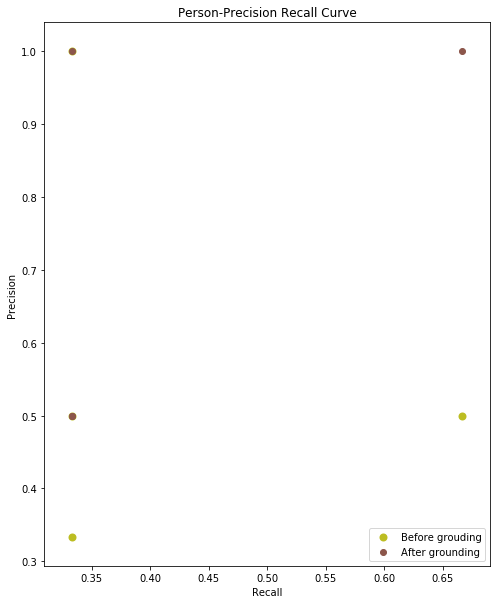

In [528]:
#comparison of the 2 curves
plt.scatter(df_toilet_sort.Recall,df_toilet_sort.Precision, c='#bcbd22', linewidths=2,label = 'Before grouding')
plt.scatter(df_toilet_sort_PR.Recall,df_toilet_sort_PR.Precision,c='#8c564b', linewidths=1, label='After grounding')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Person-Precision Recall Curve')

### AP for the 5 classes:

In [531]:
print('AP50-person: {}'.format(AP))
print('AP50-chair: {}'.format(AP_chair))
print('AP50-couch: {}'.format(AP_couch))
print('AP50-dining table: {}'.format(AP_table))
print('AP50-toilet: {}'.format(AP_toilet))

AP50-person: 0.6432169105806282
AP50-chair: 0.3299467040975858
AP50-couch: 0.38841384810724355
AP50-dining table: 0.261999283270184
AP50-toilet: 0.3333333333333333


### Result : mAP50
By average out the 5 classes AP, now we can calculate the mAP50 scores

In [533]:
average = (AP+AP_chair+AP_couch+AP_table+AP_toilet)/5
print('mAP50: {}'.format(average))

mAP50: 0.391382015877795


## mAP75 Calculation

I have walked you through the detailed calculation. Now We can do the same way to find the mAP75. I define functions to calculate the scores which can ease the writing of code.

In [5]:
df_person = pd.read_csv('df_person.csv')
df_chair = pd.read_csv('df_chair.csv')
df_couch = pd.read_csv('df_couch.csv')
df_table = pd.read_csv('df_table.csv')
df_toilet = pd.read_csv('df_toilet.csv')

In [10]:
# define an efficient function to calculate AP of each class
def AP_class(df, iou_thresold, ct_class):
    #creating TP and FP column
    df['TP'] = df.max_iou >= iou_thresold
    df['FP'] = df.max_iou < iou_thresold

    #sorting by Confidences
    df_sort = df.sort_values('Confidences', ascending=False)
    df_sort['acc_TP'] = df_sort.TP.cumsum()
    df_sort['acc_FP'] = df_sort.FP.cumsum()

    #Calculating the Precision and Recall
    df_sort['Precision'] = 0
    df_sort['Recall'] = 0
    for k in range(len(df)):
        df_sort['Precision'].iloc[k] = df_sort.acc_TP.iloc[k]/(k+1)
        df_sort['Recall'].iloc[k] = df_sort.acc_TP.iloc[k]/ct_class

    #sort out only the precision and recall for grounding
    df_sort_PR = df_sort[['Precision','Recall']]
    df_sort_PR = df_sort_PR.sort_values('Recall')

    length_df = len(df_sort_PR)
    for k in reversed(range(length_df)):
        if df_sort_PR.Precision.iloc[k] > df_sort_PR.Precision.iloc[k - 1]:
            df_sort_PR.Precision.iloc[k - 1] = df_sort_PR.Precision.iloc[k]

    # AP by All point interpolation
    AP_ = 0
    for k in reversed(range(1,length_df)):
        ap = df_sort_PR.Precision.iloc[k]*(df_sort_PR.Recall.iloc[k]-df_sort_PR.Recall.iloc[k-1])
        AP_ += ap

    return AP_

In [24]:
# optional - get the number of gt mask of each class in the dataset
def ct_class(cat_id):
    ct_test = 0
    for n in range(1000):
        img = coco.loadImgs(imgIds[n])[0]
        annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
        anns = coco.loadAnns(annIds)
        length_label = len(anns)
        for k in range(length_label):
            if anns[k]['category_id'] == cat_id:
                ct_test += 1
    return ct_test

In [27]:
ct_person = ct_class(1)
ct_chair = ct_class(62)
ct_couch = ct_class(63)
ct_table = ct_class(67)
ct_toilet = ct_class(70)
print('Number of Ground truth mask - person: {}'.format(ct_person))
print('Number of Ground truth mask - chair: {}'.format(ct_chair))
print('Number of Ground truth mask - couch: {}'.format(ct_couch))
print('Number of Ground truth mask - dining table: {}'.format(ct_table))
print('Number of Ground truth mask - toilet: {}'.format(ct_toilet))

Number of Ground truth mask - person: 3542
Number of Ground truth mask - chair: 3403
Number of Ground truth mask - couch: 277
Number of Ground truth mask - dining table: 749
Number of Ground truth mask - toilet: 3


### AP of each class

In [28]:
AP_person_75 = AP_class(df_person, 0.75, ct_person)
AP_chair_75 = AP_class(df_chair, 0.75, ct_chair)
AP_couch_75 = AP_class(df_couch, 0.75, ct_couch)
AP_table_75 = AP_class(df_table, 0.75, ct_table)
AP_toilet_75 = AP_class(df_toilet, 0.75, ct_toilet)

print('AP75-person: {}'.format(AP_person_75))
print('AP75-chair: {}'.format(AP_chair_75))
print('AP75-couch: {}'.format(AP_couch_75))
print('AP75-dining table: {}'.format(AP_table_75))
print('AP75-toilet: {}'.format(AP_toilet_75))

/Users/matthewyeung/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


AP75-person: 0.4396313983674775
AP75-chair: 0.138759481532497
AP75-couch: 0.21482218468076866
AP75-dining table: 0.14169639545015103
AP75-toilet: 0.08333333333333333


### mAP75

In [29]:
average_75 = (AP_person_75 + AP_chair_75 + AP_couch_75 + AP_table_75 + AP_toilet_75)/5
print('mAP75: {}'.format(average_75))

mAP75: 0.2036485586728455
